In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

## 증시 예측 s2s (sequence 2 sequence )
- 데이터 유효성, 누락 검사
- 분포, 상관관계 분석
- 전처리 : X(이동 평균(5일)), Y(다음 5일날 종가) 분리, 정규화
- LinearRegression 점수 측정, tensorflow RNN(s2s model)
- 그래프로 시각화 (역 정규화) 

In [4]:
삼성 = '005930'
삼천리자전거 = '024950'
url_base = 'https://finance.naver.com/item/sise_day.nhn?code='
url = url_base + 삼성 +'&page='
page_list = []
max_page = 31 
for page in range(1, max_page):
    tables = pd.read_html(url+str(page))
    page_list.append(tables[0]) # 네이버는 첫번쨰 테이블[0]이 증시데이터 입니다.
len(page_list)

30

In [5]:
df = pd.concat(page_list, axis=0)
df = df.dropna()
df = df.set_index('날짜').drop(columns='전일비')
df = df.iloc[::-1] # 행을 반대로 뒤집기 

In [7]:
df.tail()

,종가,시가,고가,저가,거래량
날짜,,,,,
2019.09.06,46300.0,46500.0,46500.0,45850.0,9896562.0
2019.09.09,46900.0,46450.0,47000.0,46300.0,9434157.0
2019.09.10,47000.0,47100.0,47200.0,46550.0,9231792.0
2019.09.11,47150.0,47300.0,47400.0,46800.0,16141619.0
2019.09.16,46850.0,47000.0,47050.0,46400.0,7535946.0


In [8]:
df.isna().sum().sum()

0

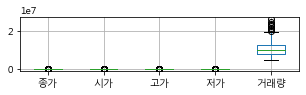

In [9]:
df.boxplot(figsize=(5,1))

In [10]:
df.corr() #상관 관계 

,종가,시가,고가,저가,거래량
종가,1.000000,0.971356,0.988014,0.988119,-0.265039
시가,0.971356,1.000000,0.987047,0.988238,-0.253554
고가,0.988014,0.987047,1.000000,0.988747,-0.222987
저가,0.988119,0.988238,0.988747,1.000000,-0.291071
거래량,-0.265039,-0.253554,-0.222987,-0.291071,1.000000


In [130]:
df.corr()

,종가,시가,고가,저가,거래량
종가,1.000000,0.970845,0.988021,0.987957,-0.268811
시가,0.970845,1.000000,0.986696,0.988068,-0.257964
고가,0.988021,0.986696,1.000000,0.988656,-0.226417
저가,0.987957,0.988068,0.988656,1.000000,-0.295684
거래량,-0.268811,-0.257964,-0.226417,-0.295684,1.000000


In [12]:
x = df.iloc[:-1] # 전날
y = df.iloc[1:]['종가'] # 다음날

In [13]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x, y)
model.score(x, y)

0.9119347255188083

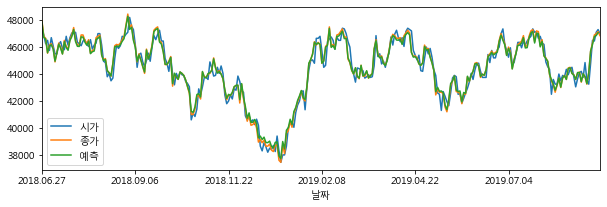

In [14]:
df[['시가', '종가']].plot(figsize=(10, 3))
plt.plot(model.predict(x), label='예측')
plt.legend()

전일비를 추가하자

In [15]:
#전일비 = 다음날 ? - 전날 ?
전일비 = df.iloc[1:]['시가']  - df.iloc[:-1]['종가'] 
df['전일비'] = 전일비
df = df.dropna()
#전일비

이동평균을 넣어보자

In [16]:
df_rol = df.rolling(window=5).mean()

In [17]:
df_rol.columns = ['종가_rol', '시가_rol', '고가_rol', '저가_rol', '거래량_rol','전일비_rol'] 

In [18]:
df_con = pd.concat((df, df_rol), axis=1).dropna()
df_con.head(1)

,종가,시가,고가,저가,거래량,전일비,종가_rol,시가_rol,고가_rol,저가_rol,거래량_rol,전일비_rol
날짜,,,,,,,,,,,,
2018.07.04,46250.0,46700.0,47050.0,46050.0,8776763.0,450.0,46280.0,46410.0,46990.0,46020.0,11946621.2,130.0


지금까지는 데이터에 시간축이 없었습니다

X 는 과거의 5일치 데이터입니다 
Y 는 미래의 5일치 데이터입니다
데이터가 10일치가 있었다면 X, Y 1 셋트 만들 수 있습니다 
데이터가 11일치가 있었다면 X, Y 2 셋트 만들 수 있습니다 

m_seq = m - (x_seq + y_seq) + 1
1     = 10 - ( 5 + 5) + 1
2     = 11 - ( 5 + 5) + 1
285   = 294 -( 5 + 5) + 1

In [21]:
df_con.shape, len(df_con)

((294, 12), 294)

In [63]:
x_T = 10
y_T = 5
# X (285, 5, 12), y (285, 5)
x_list = []
y_list = []
for i in range(len(df_con) - (x_T + y_T) + 1): # 285번 반복 
    x = df_con.iloc[i : i+x_T] #[0:5] 과거의 5일
    y = df_con.iloc[i+x_T : i+x_T+y_T]['종가'] #[5:10] 미래의 5일
    x_list.append(x)
    y_list.append(y)
len(x_list), len(y_list)

(280, 280)

In [64]:
X = np.stack(x_list, axis=0).astype(np.float32)
y = np.stack(y_list, axis=0).astype(np.float32)
type(X), X.shape, y.shape, X.dtype, y.dtype

(numpy.ndarray, (280, 10, 12), (280, 5), dtype('float32'), dtype('float32'))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X_2d = X.reshape([-1, 12]) # 3d > 2d
y_2d = y.reshape([-1, 1]) # 특징 5개가 아니고 , 특징 1개 이므로 
scaler_x = MinMaxScaler().fit(X_2d)
scaler_y = MinMaxScaler().fit(y_2d)
xn = scaler_x.transform(X_2d)
yn = scaler_y.transform(y_2d)
xn = xn.reshape(X.shape) # 2d > 3d
yn = yn.reshape(y.shape)
xn.shape, yn.shape,  np.min(xn), np.max(xn), np.min(yn), np.max(yn)

In [41]:
import tensorflow.contrib.slim as slim
tf.reset_default_graph()
cell_enc = tf.nn.rnn_cell.GRUCell(100, name='enc')
cell_dec = tf.nn.rnn_cell.GRUCell(100, name='dec')
net = slim.conv1d(xn, num_outputs=10, kernel_size=3)
outputs, last_state = tf.nn.dynamic_rnn(cell_enc, net, dtype=tf.float32)
zero = tf.zeros([len(xn), y_T, 1]) # x와 y 의 시퀀스가 다를 때 
context_vector = last_state # 모든 정보가 이 안에 있습니다
outputs, last_state = tf.nn.dynamic_rnn(cell_dec,zero,initial_state=context_vector)
h = slim.fully_connected(outputs, 1)
h = tf.squeeze(h, axis=-1) #맨 뒤쪽 차원을 제거해라 
cost = tf.reduce_mean((yn - h)**2)
train = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [53]:
for i in range(1000):
    _, c = sess.run([train, cost])    
    #if i%100 == 0: print(i, c)
print(i, c)

999 0.010938753


In [62]:
from sklearn.metrics import r2_score
predict = sess.run(h) # 미래 5일 예측 종가
for i in range(y_T):
    print(i+1, '일 후', r2_score(yn[:, [i]], predict[:, [i]]))

1 일 후 0.8772743189056558
2 일 후 0.806552947698169
3 일 후 0.7342200458163912
4 일 후 0.665505115185024
5 일 후 0.5998576901910064


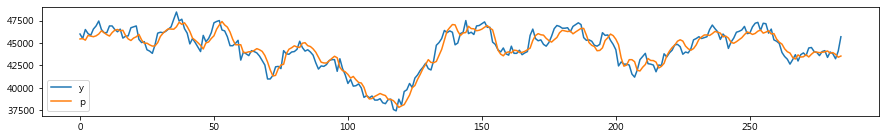

In [57]:
plt.figure(figsize=(15,2))
plt.plot(scaler_y.inverse_transform(yn[:, [0]]), label='y')
plt.plot(scaler_y.inverse_transform(predict[:, [0]]), label='p')
plt.legend()

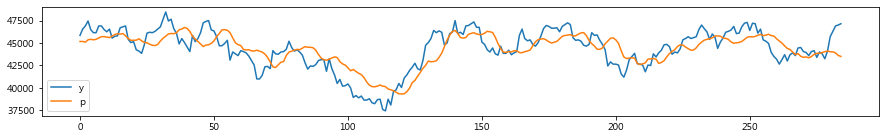

In [49]:
plt.figure(figsize=(15,2))
plt.plot(scaler_y.inverse_transform(yn[:, [4]]), label='y')
plt.plot(scaler_y.inverse_transform(predict[:, [4]]), label='p')
plt.legend()